<a href="https://colab.research.google.com/github/rickyprimay/smart_waste_classification_model/blob/main/klasifikasi_sampah_organik_dan_anorganik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rickyprima","key":"3ff45033662589c4af070d5c89a0eb3e"}'}

In [4]:
# Membuat directory bernama kaggle dan copy file kaggle.json disana
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# Mengubah permission file
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Mengunduh Dataset
dataset_name = 'techsash/waste-classification-data'
!kaggle datasets download -d {dataset_name}

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 99% 425M/427M [00:19<00:00, 24.9MB/s]
100% 427M/427M [00:19<00:00, 22.7MB/s]


In [6]:
# Melakukan ekstraksi pada file zip
import zipfile,os

# Lokasi file zip yang telah diunduh
local_zip = 'waste-classification-data.zip'

if not os.path.exists('dataset'):
    # Jika belum ada, maka buat direktori baru
    os.mkdir('dataset')

zip_ref = zipfile.ZipFile(local_zip, 'r') # membuka file zip
zip_ref.extractall('/dataset') # mengekstrak semua isi file zip ke direktori dataset
zip_ref.close() # menutup file zip yang telah di ekstrak


dataset = os.path.join('/dataset')
print(os.listdir(dataset))

['DATASET', 'dataset']


In [7]:
base_dir = '/dataset/DATASET/TEST/' # direktori utama tempat data akan disimpan
print(os.listdir(base_dir))

['R', 'O']


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, _ in os.walk('/dataset/DATASET'):
        print(dirname)

/dataset/DATASET
/dataset/DATASET/TEST
/dataset/DATASET/TEST/R
/dataset/DATASET/TEST/O
/dataset/DATASET/TRAIN
/dataset/DATASET/TRAIN/R
/dataset/DATASET/TRAIN/O


In [9]:
train_path = "/dataset/DATASET/TRAIN/"
test_path = "/dataset/DATASET/TEST/"

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model

from glob import glob

In [11]:
x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 12565/12565 [00:07<00:00, 1750.87it/s]


In [12]:
data.shape

(22564, 2)

In [13]:
from collections import Counter
Counter(y_data)

Counter({'R': 9999, 'O': 12565})

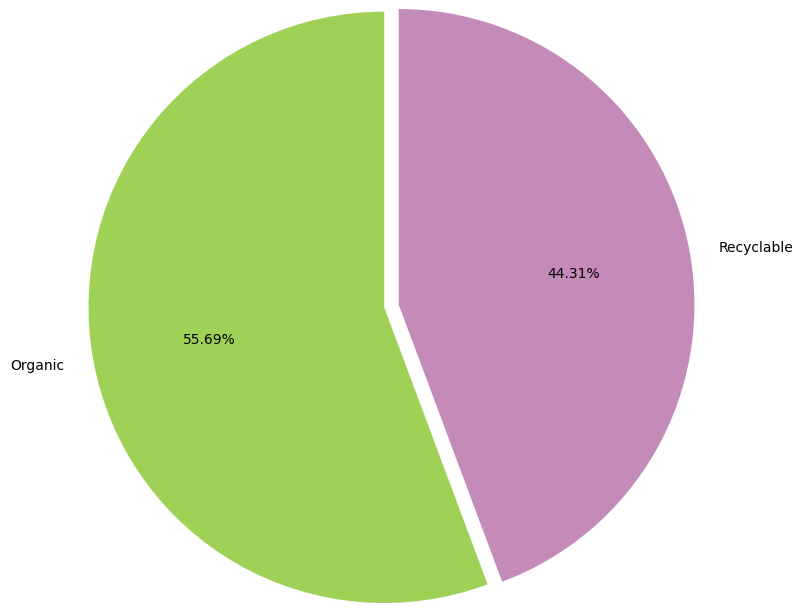

In [14]:
colors = ['#a0d157','#c48bb8']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

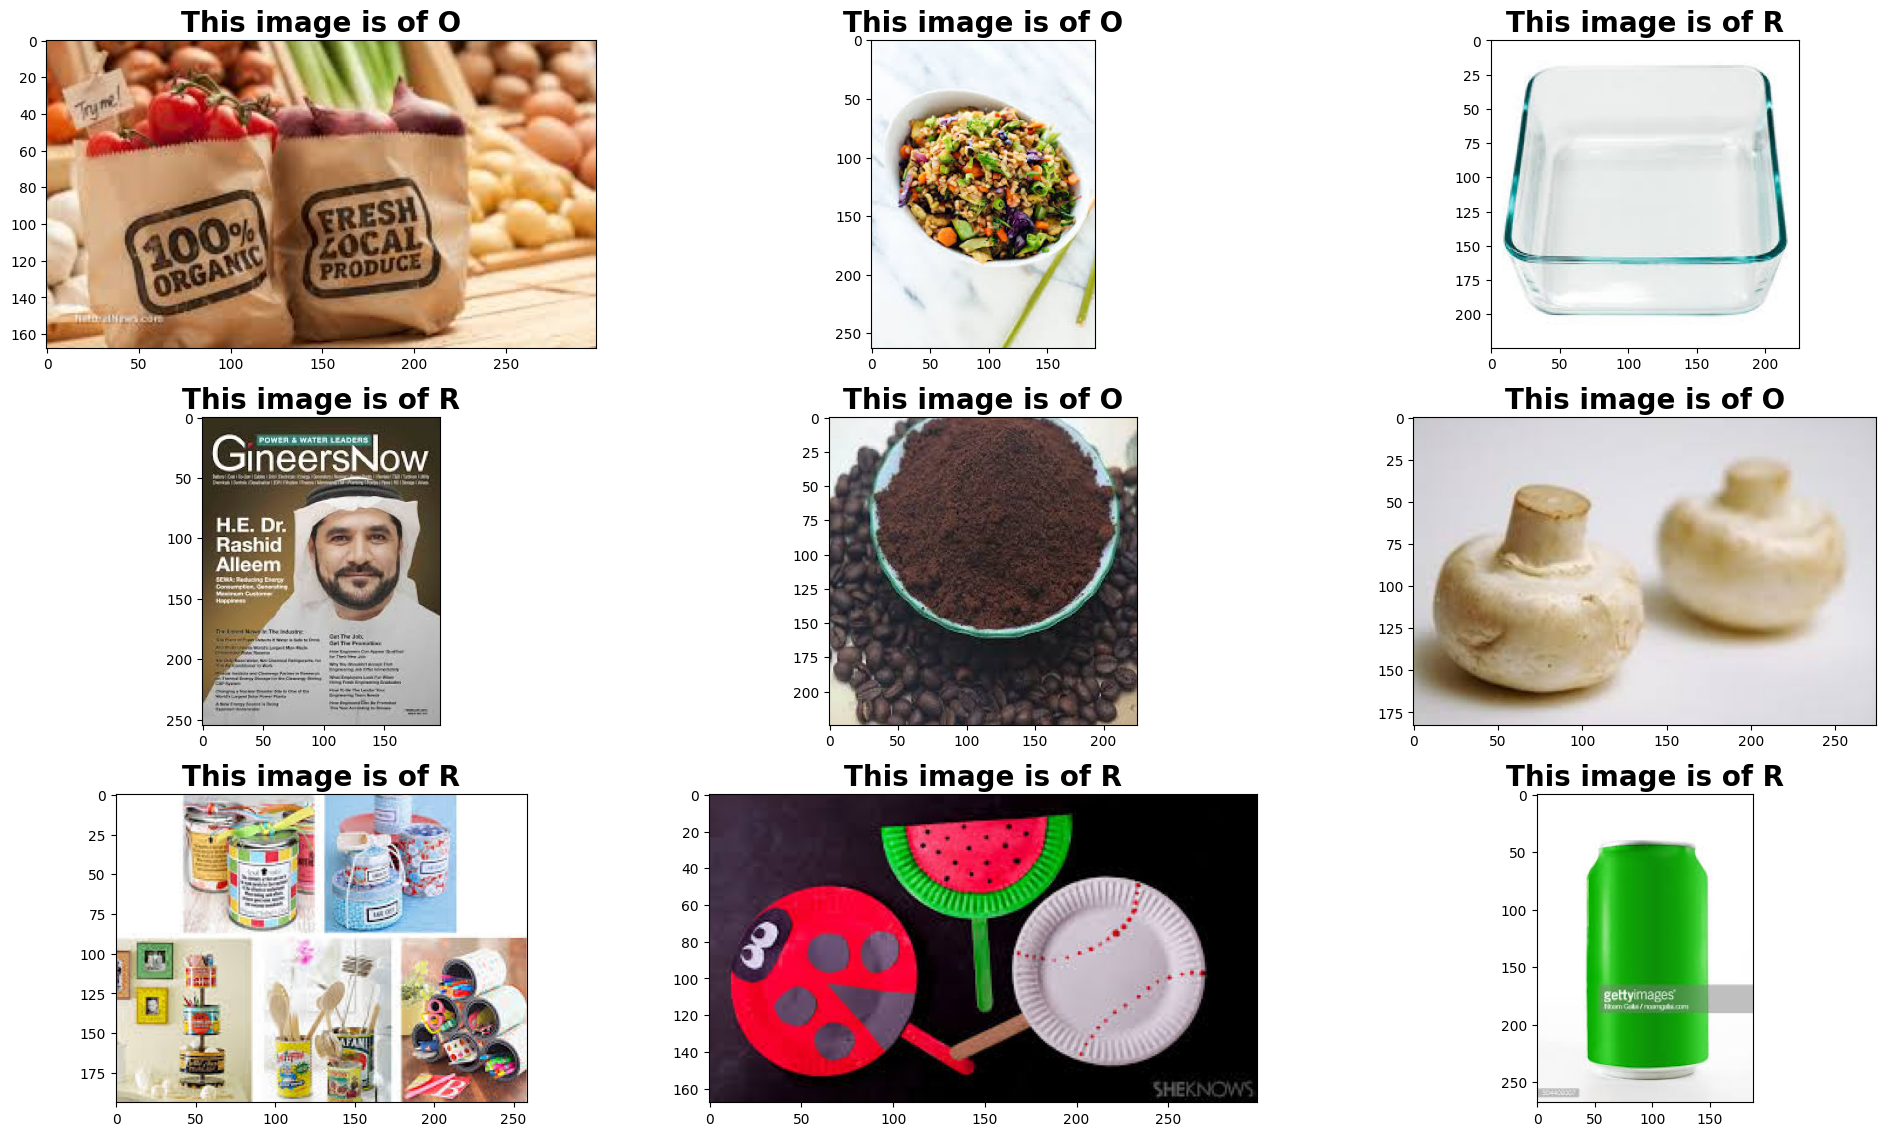

In [15]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [16]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


In [17]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass))
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

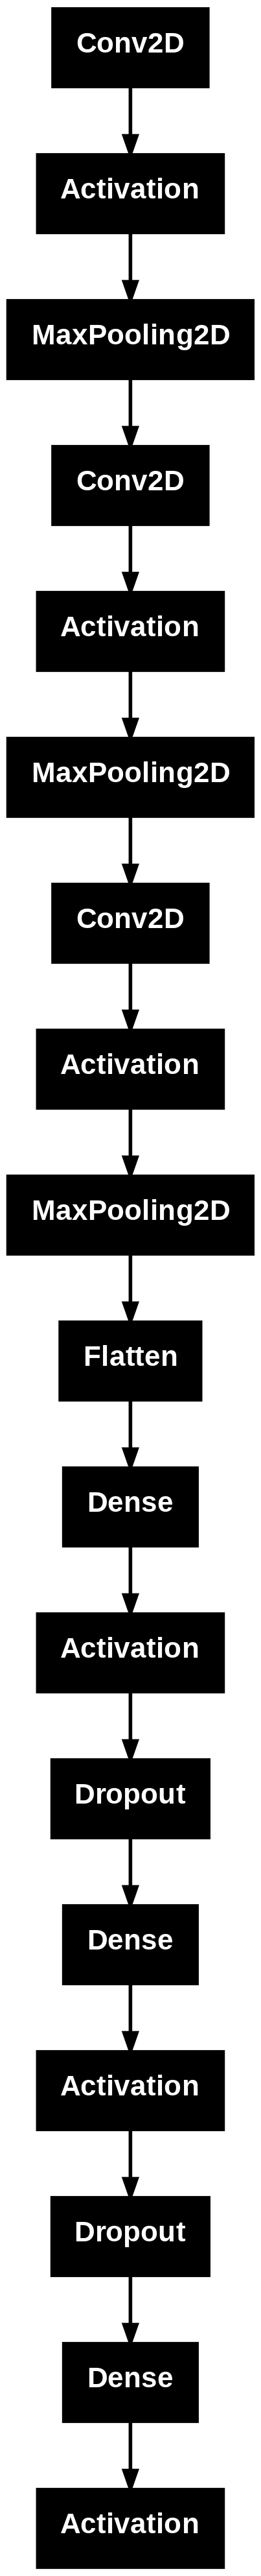

In [18]:
plot_model(model)

In [19]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [20]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [21]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [22]:
hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 109s 882ms/step - accuracy: 0.6874 - loss: 0.7093 - val_accuracy: 0.8651 - val_loss: 0.3728
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 93s 613ms/step - accuracy: 0.8217 - loss: 0.4279 - val_accuracy: 0.8492 - val_loss: 0.3828
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 87s 674ms/step - accuracy: 0.8408 - loss: 0.3917 - val_accuracy: 0.8782 - val_loss: 0.2956
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 59s 621ms/step - accuracy: 0.8640 - loss: 0.3413 - val_accuracy: 0.8365 - val_loss: 0.3791
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 59s 618ms/step - accuracy: 0.8681 - loss: 0.3246 - val_accuracy: 0.8671 - val_loss: 0.3341
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 58s 618ms/step - accuracy: 0.8775 - loss: 0.3039 - val_accuracy: 0.9001 - val_loss: 0.2702
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 83s 625ms/step - accuracy: 0.8909 - loss: 0.2726 - val_accuracy: 0.9009 - val_loss: 0.2815
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 618ms/step - accuracy: 0.9087 - loss: 0.2361 - val_acc

In [23]:
def predict_func(img):
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
This image -> Organic


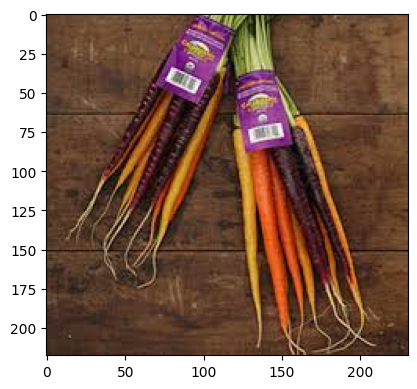

In [24]:
test_img = cv2.imread("/dataset/DATASET/TEST/O/O_12573.jpg")
predict_func(test_img)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 482ms/step - accuracy: 0.8993 - loss: 0.2970
Test accuracy: 0.8997214436531067
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 544ms/step
              precision    recall  f1-score   support

           O       0.57      0.57      0.57      1401
           R       0.45      0.45      0.45      1112

    accuracy                           0.52      2513
   macro avg       0.51      0.51      0.51      2513
weighted avg       0.52      0.52      0.52      2513

[[797 604]
 [612 500]]


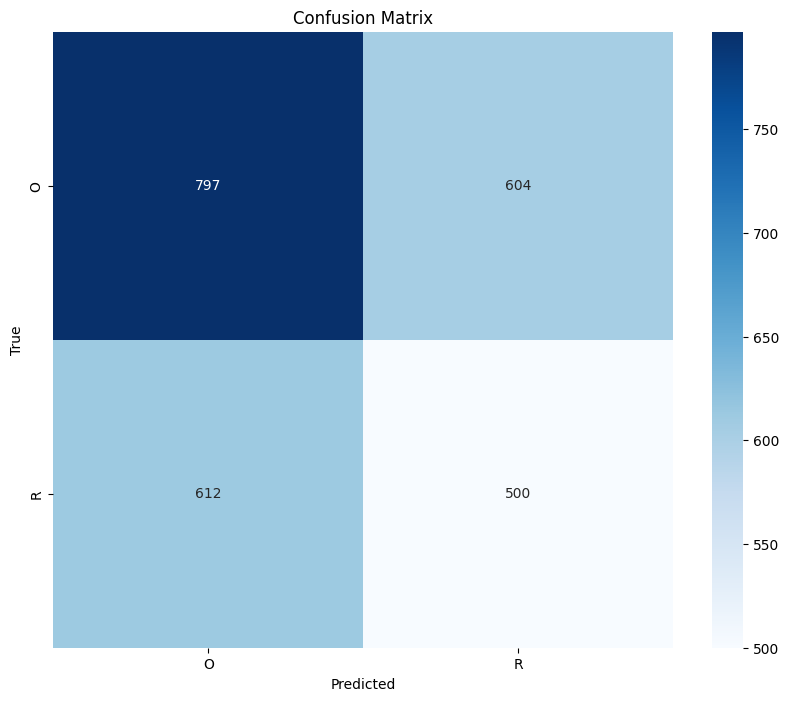

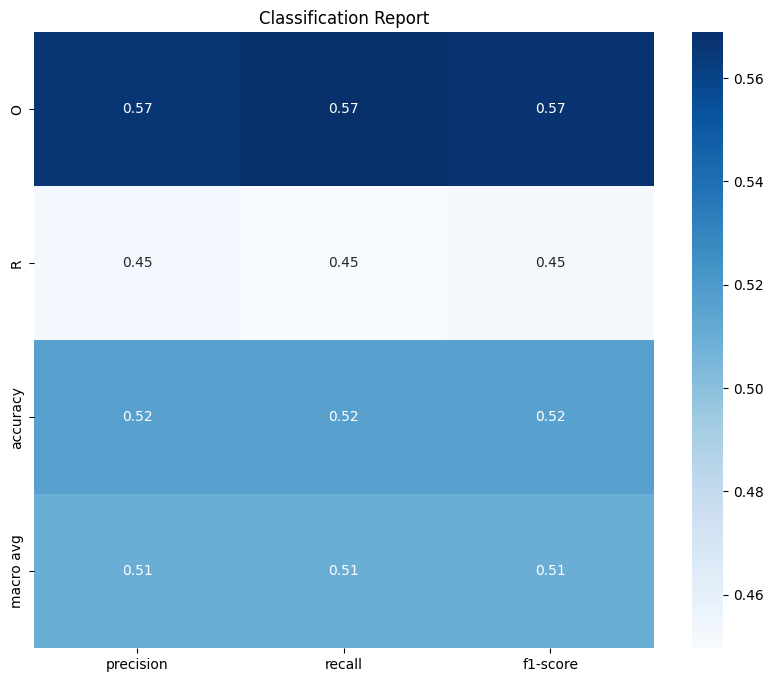

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc}")

# Prediksi nilai dari dataset validasi
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Mendapatkan label sebenarnya
y_true = test_generator.classes

# Laporan Klasifikasi
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# Matriks Kebingungan
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Visualisasi Matriks Kebingungan
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualisasi Laporan Klasifikasi
from pandas import DataFrame
report_data = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
report_df = DataFrame(report_data).transpose()
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()


In [26]:
saved_model_path = "./classification_garbage_test.h5"
model.save(saved_model_path)

In [27]:
import h5py

try:
    with h5py.File('/content/classification_garbage_test.h5', 'r') as f:
        print("File valid dan dapat dibuka.")
except OSError as e:
    print(f"Error: {e}")

File valid dan dapat dibuka.


In [28]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./model/tfjs_fromKeras/

/bin/bash: line 1: tensorflowjs_converter: command not found


In [29]:
class_labels = train_generator.class_indices

print(class_labels)

{'O': 0, 'R': 1}


In [30]:
import shutil

folder_path = './model/tfjs_fromKeras/'

zip_file_name = '/content/tfjs_model_kera.zip'

shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', folder_path)

print(f"Folder has been zipped to {zip_file_name}")

Folder has been zipped to /content/tfjs_model_kera.zip
